In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Tutorial on human data

### Read in data

In [2]:
seqs = pd.read_csv('human_seqs.txt')
seqs.head()

,Sequence,Group,K562_l2fc,MinGap,K562_lfcSE,K562_prediction,SeqID
0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp,6.693819,11.262747,0.527668,6.363210,0
1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp,6.488648,10.065946,0.611020,4.845627,1
2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp,5.479217,9.571529,0.361232,5.632198,2
3,GCTCTTGACACGCGCGAACACGTTGAGTTTGAGCGGGACGAGATAG...,FastSeqProp,5.153645,9.568642,0.357879,8.558550,3
4,CCTCGATCATCTTGCACGGGTACCGGTAAGTCATGAGTGTAGCGCT...,FastSeqProp,4.641555,9.185362,0.684389,6.245122,4


In [3]:
print(seqs.Group.value_counts())

Group
FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: count, dtype: int64


# 1. Sequence composition

## 1.1 GC Content

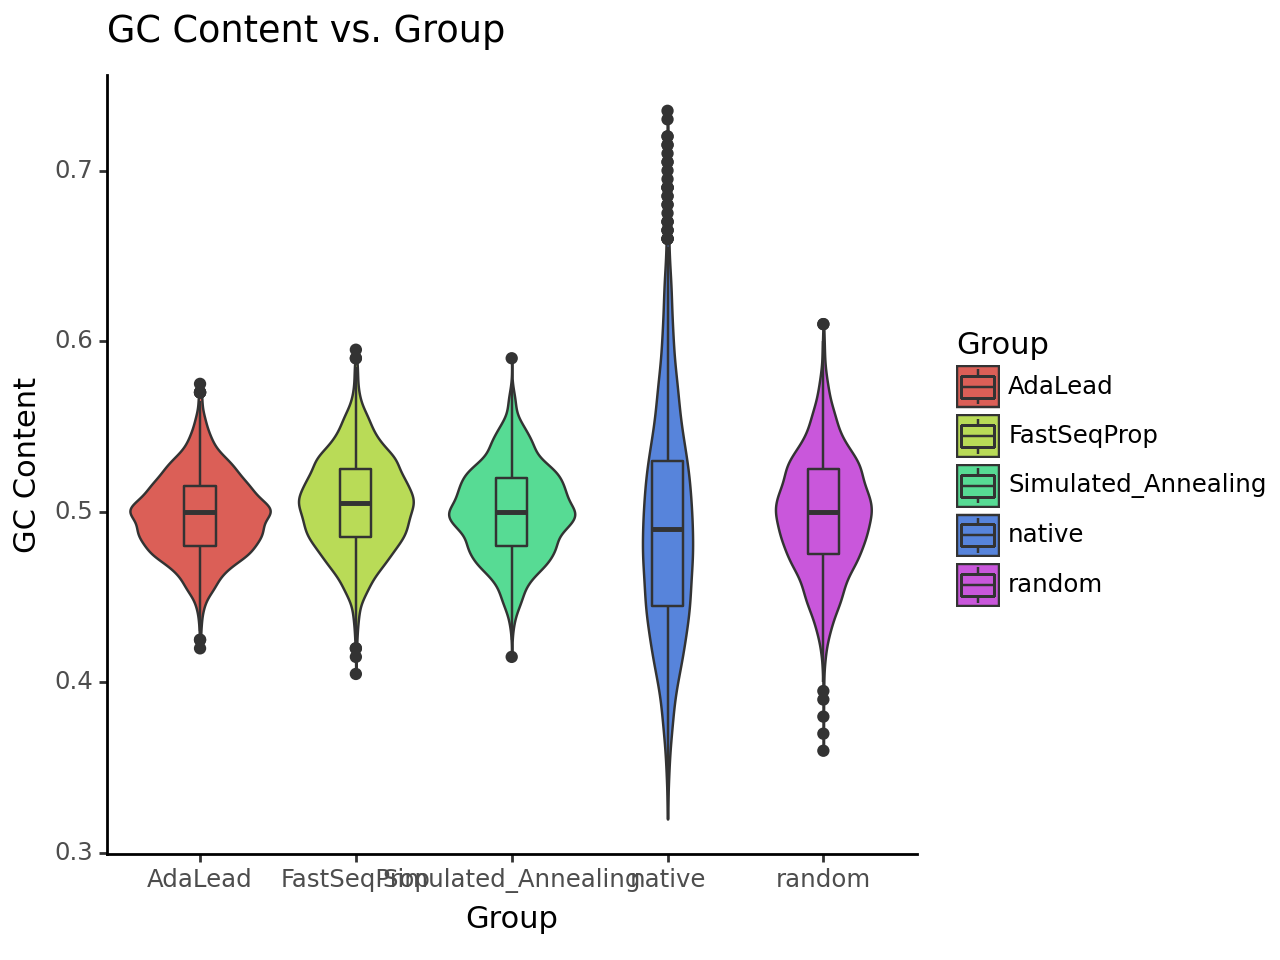

<Figure Size: (640 x 480)>

In [5]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(8, 4))

In [6]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
 AdaLead              1.000000e+00  1.339813e-10         8.475353e-02   
 FastSeqProp          1.339813e-10  1.000000e+00         3.600121e-04   
 Simulated_Annealing  8.475353e-02  3.600121e-04         1.000000e+00   
 native               7.994550e-06  1.277959e-30         3.789485e-13   
 random               1.000000e+00  1.057243e-06         1.000000e+00   
 
                            native        random  
 AdaLead              7.994550e-06  1.000000e+00  
 FastSeqProp          1.277959e-30  1.057243e-06  
 Simulated_Annealing  3.789485e-13  1.000000e+00  
 native               1.000000e+00  1.734562e-09  
 random               1.734562e-09  1.000000e+00  }

## 1.2 Length distribution

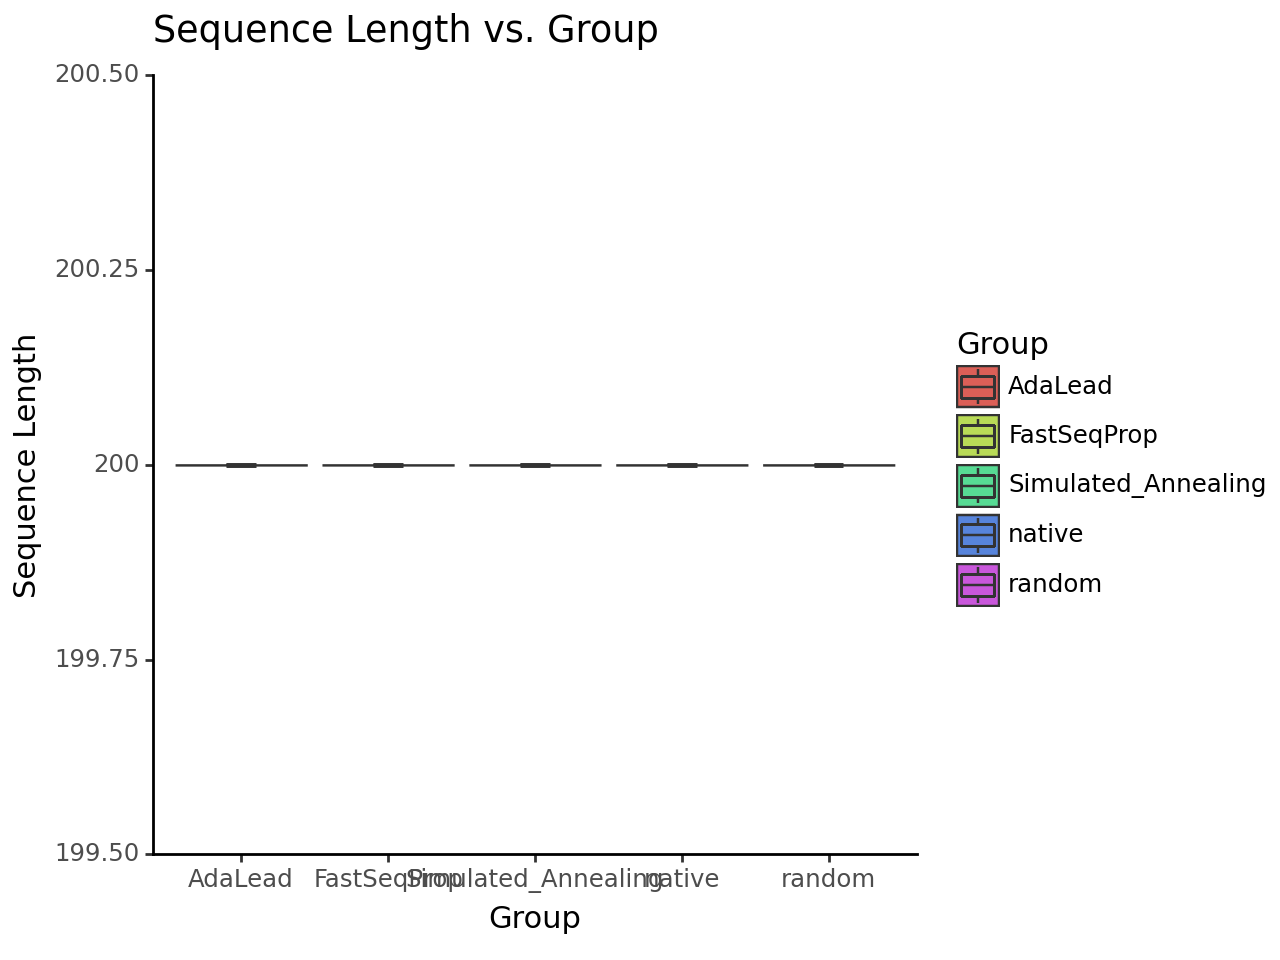

<Figure Size: (640 x 480)>

In [7]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length')

## 1.3 k-mer content

In [8]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 17.5 s, sys: 387 ms, total: 17.9 s
Wall time: 17.9 s


In [9]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.24987976011050114
UMAP
Differential feature abundance
1-NN statistics


/opt/conda/lib/python3.8/site-packages/polygraph/stats.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 3min 4s, sys: 24.1 s, total: 3min 28s
Wall time: 45.1 s


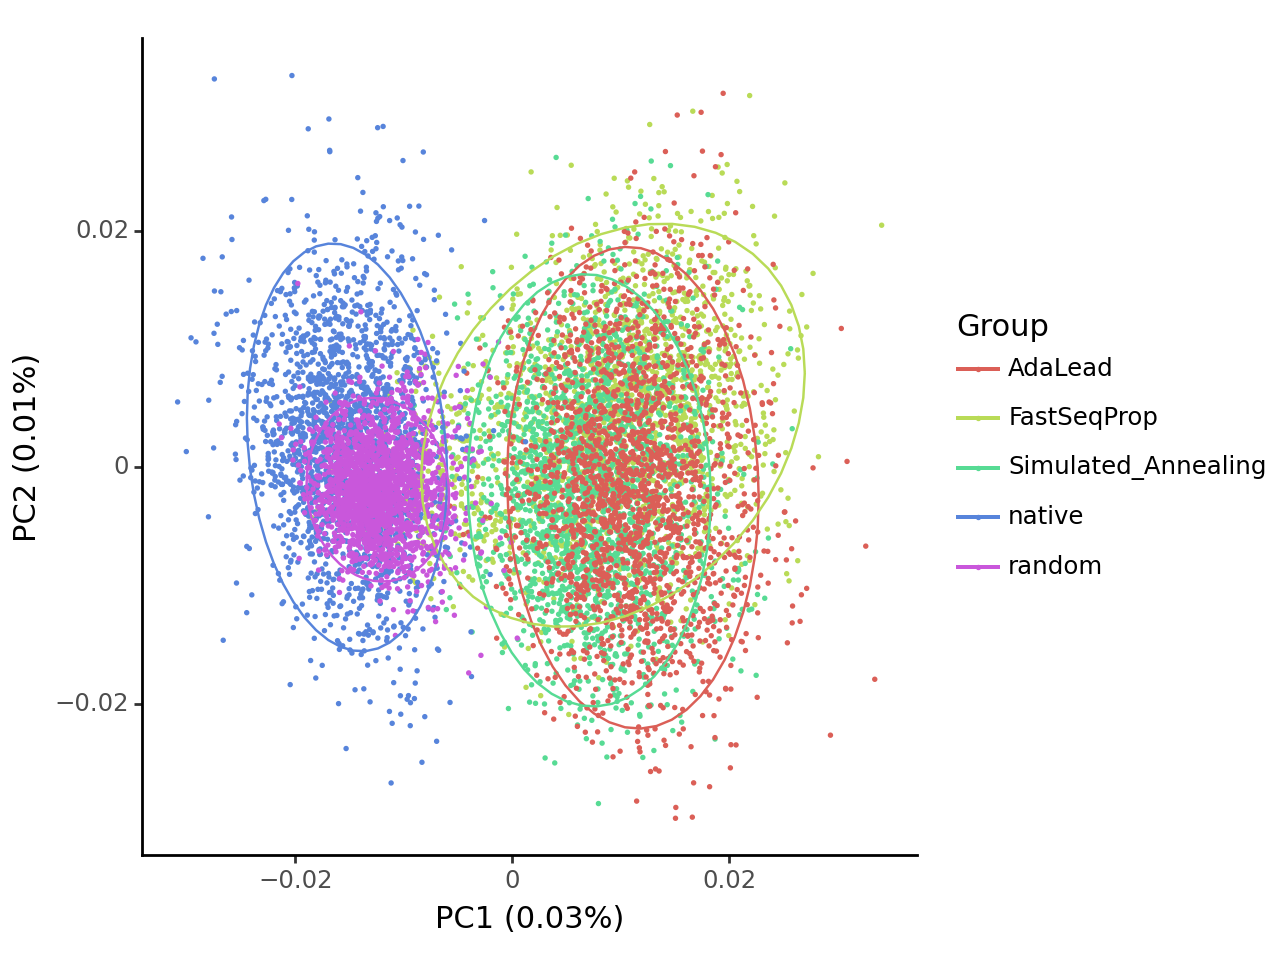

<Figure Size: (640 x 480)>

In [10]:
polygraph.visualize.pca_plot(emb)

In [11]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: count, dtype: int64

Top Differential k-mers
                    Group  value      score           padj
1024          FastSeqProp  GATAA  38.483311   0.000000e+00
0                 AdaLead  TTATC  36.801987  1.757215e-293
1025          FastSeqProp  TTATC  34.037605  3.170041e-251
2048  Simulated_Annealing  TTATC  33.948215  1.327107e-249
1                 AdaLead  GATAA  33.635479  2.603204e-245
1026          FastSeqProp  ATAAG  33.599346  5.853254e-245
2                 AdaLead  CTTAT  32.068928  4.082288e-223
3                 AdaLead  TGTCA  31.905781  5.683173e-221
1027          FastSeqProp  CTTAT  31.818279  9.259396e-220
4                 AdaLead  TGACA  30.834171  1.870147e-206


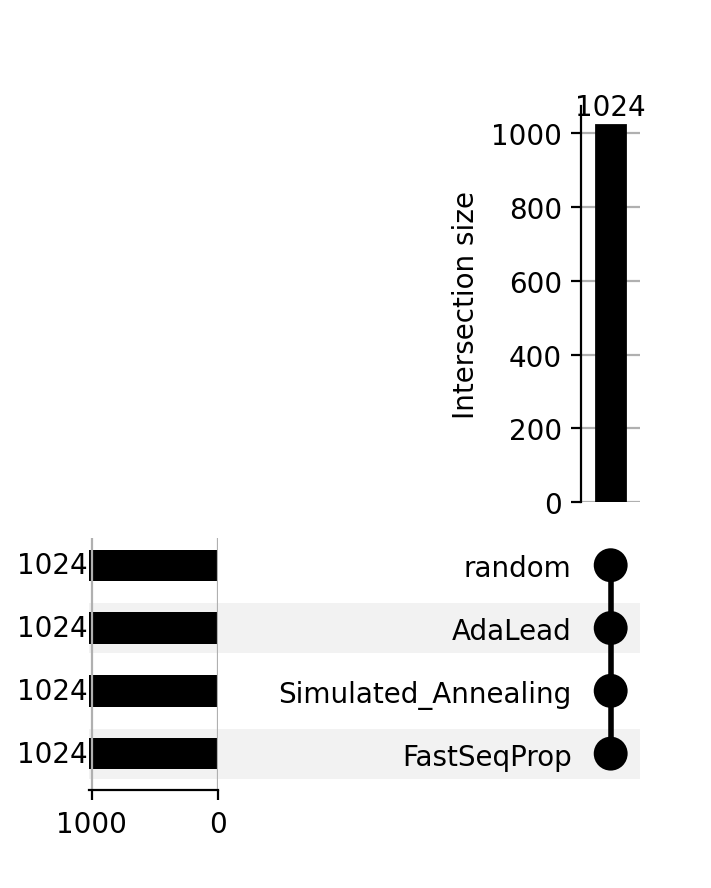

In [12]:
# kmer occurrence
polygraph.visualize.upset_plot(emb[emb.obs.Group!='native'])

In [13]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.43         0.16                 0.40    0.00    0.00
FastSeqProp             0.06         0.69                 0.14    0.00    0.10
Simulated_Annealing     0.25         0.24                 0.46    0.00    0.05
native                  0.00         0.01                 0.00    0.88    0.11
random                  0.00         0.03                 0.00    0.01    0.96

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0045     0.879   0.0   0.0
Simulated_Annealing      0.0035     0.879   0.0   0.0
AdaLead                  0.0010     0.879   0.0   0.0
random                   0.0120     0.879   0.0   0.0


p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.000000e+00  7.519483e-34         1.230345e-41     0.0   
FastSeqProp          7.519483e-34  1.000000e+00         1.000000e+00     0.0   
Simulated_Annealing  1.230345e-41  1.000000e+00         1.000000e+00     0.0   
native               0.000000e+00  0.000000e+00         0.000000e+00     1.0   
random               0.000000e+00  0.000000e+00         0.000000e+00     1.0   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  1.0  
random                  1.0  }


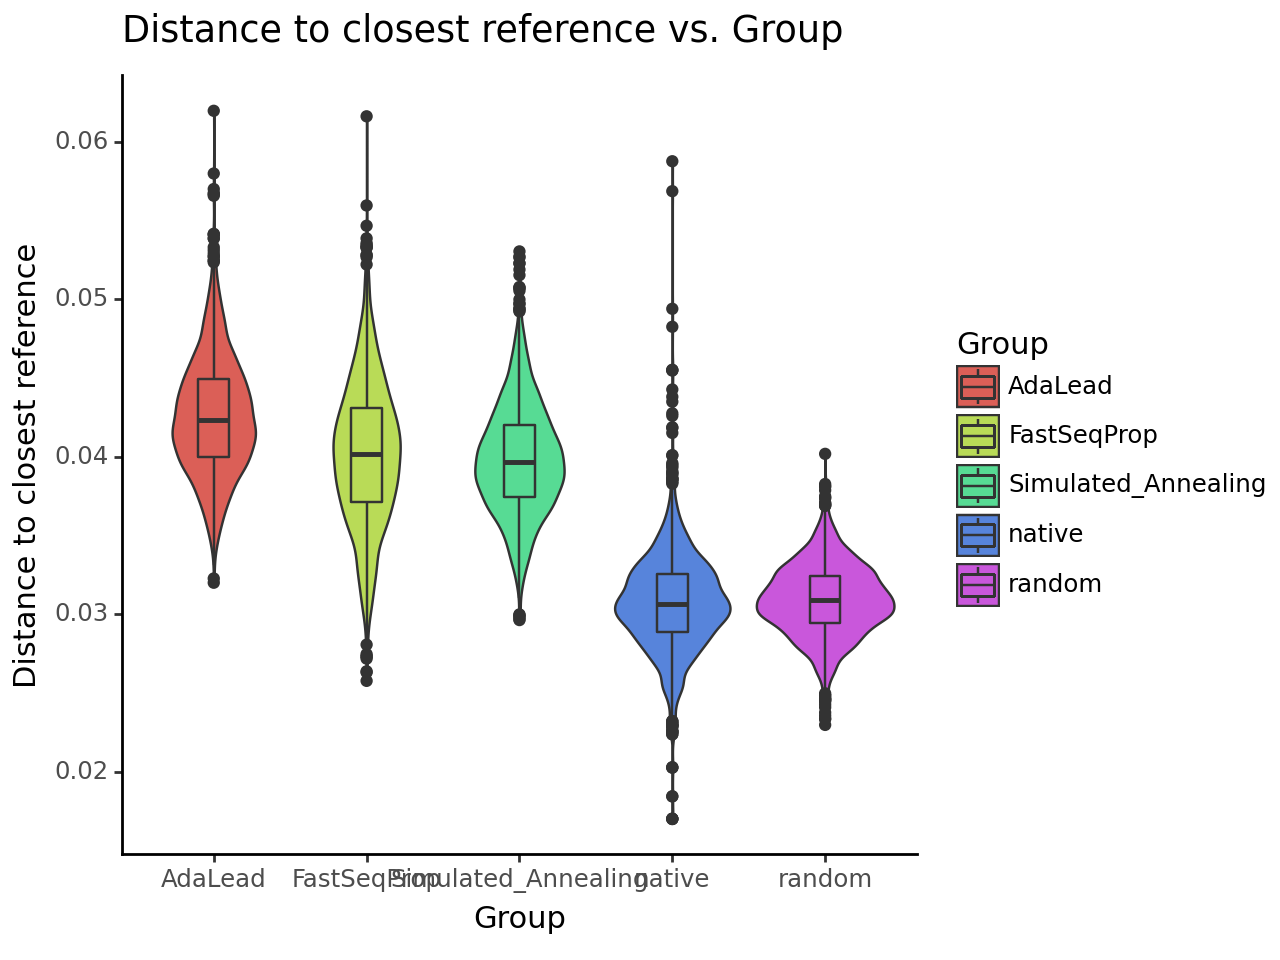

<Figure Size: (640 x 480)>

In [14]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference')

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                            AdaLead    FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  9.384288e-186         1.890244e-46   
FastSeqProp          9.384288e-186   1.000000e+00         9.106645e-48   
Simulated_Annealing   1.890244e-46   9.106645e-48         1.000000e+00   
native               3.060118e-216   2.066646e-01         9.638958e-64   
random                0.000000e+00   0.000000e+00         0.000000e+00   

                            native  random  
AdaLead              3.060118e-216     0.0  
FastSeqProp           2.066646e-01     0.0  
Simulated_Annealing   9.638958e-64     0.0  
native                1.000000e+00     0.0  
random                0.000000e+00     1.0  }


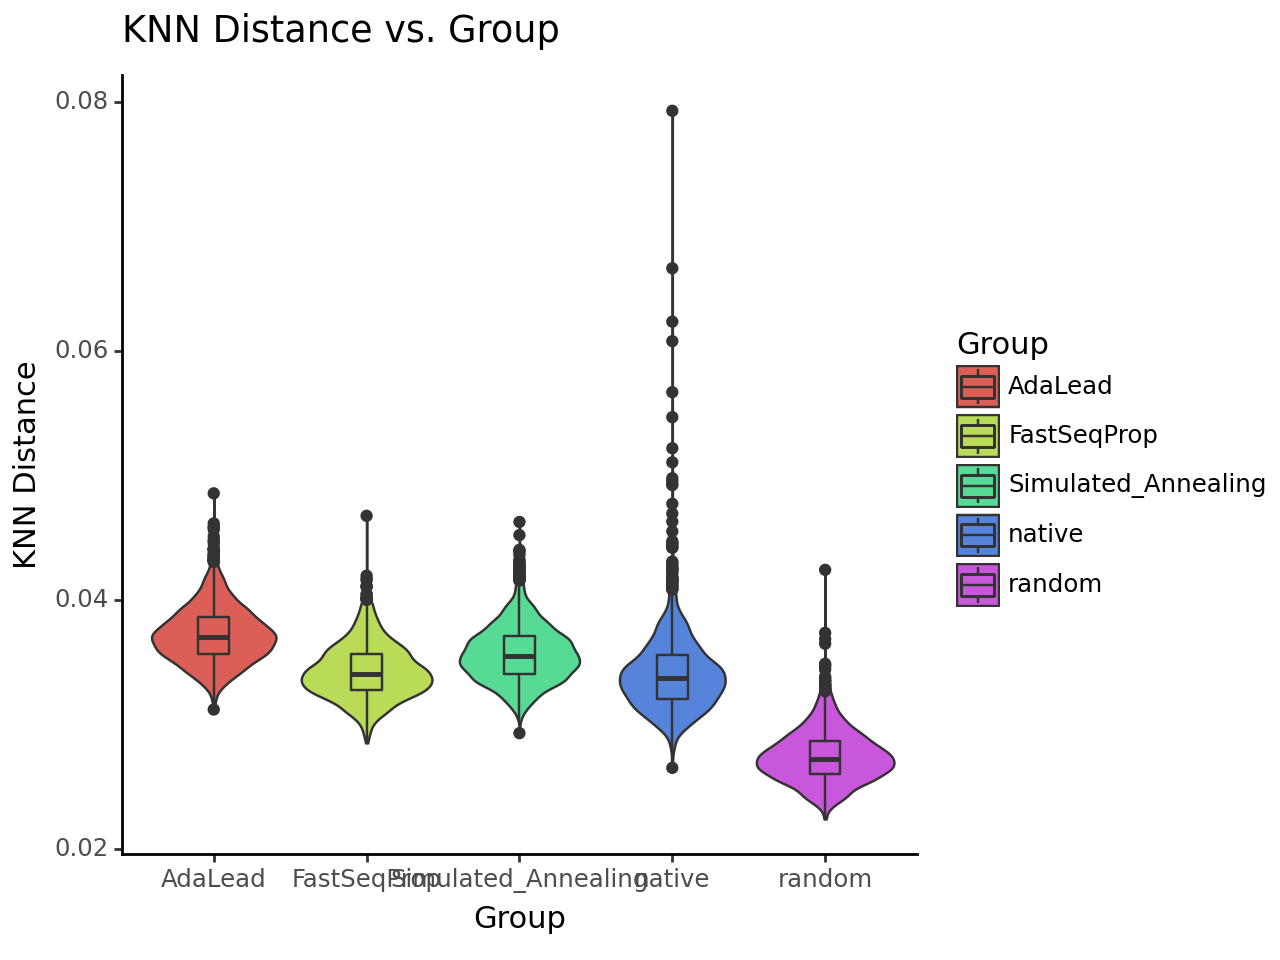

<Figure Size: (640 x 480)>

In [15]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance')

## 2. Motif content

In [22]:
jaspar = polygraph.input.load_jaspar()

--2023-11-28 04:39:10--  https://jaspar.genereg.net/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt
Resolving jaspar.genereg.net (jaspar.genereg.net)... 193.60.222.202
Connecting to jaspar.genereg.net (jaspar.genereg.net)|193.60.222.202|:443... connected.
	requested host name ‘jaspar.genereg.net’.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://jaspar.elixir.no/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt [following]
--2023-11-28 04:39:11--  https://jaspar.elixir.no/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179, 2001:700:2:8200::26fc
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327864 (320K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2022_CORE

In [23]:
len(jaspar)

841

In [ ]:
%%time 
counts = polygraph.motifs.motif_frequencies(seqs, jaspar, num_workers=8, normalize=True)

Processing motifs
Scanning


In [ ]:
meta = pd.DataFrame(counts.columns, columns=['MotifID'])
counts = counts.loc[:, ~counts.columns.isna()]

In [ ]:
counts.to_csv('human_counts.csv', index=False)

In [ ]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native')

In [ ]:
polygraph.visualize.pca_plot(emb)

In [ ]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

In [ ]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

In [ ]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference')

In [ ]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance')

## 2.2 Motif combinations

In [ ]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(counts.iloc[:50, :50], seqs, reference_group='native')

In [ ]:
len(set(motif_combinations.combination))

In [ ]:
motif_combinations.sort_values('padj').head(10)

In [ ]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [ ]:
sig_combs[sig_combs.Group=='FastSeqProp']

## 2.3 Motif positions

In [ ]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

In [ ]:
%%time
sites = polygraph.motifs.scan_seqs(seqs, [m for m in jaspar if m.name=="GATA5"], num_workers=8)
sites.head()

In [ ]:
polygraph.visualize.densityplot(sites, value_col='start')

In [ ]:
polygraph.stats.kruskal_dunn(sites, val_col='start')

## 2.4 NMF

In [ ]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

In [ ]:
p[p.padj < .001]

In [ ]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

In [ ]:
polygraph.visualize.plot_factors_nmf(H, n_features=25)

# 3. Model predictions

### Load model trained on catlas data

In [33]:
import torch
model = torch.load('catlas-enformer-release-model_2.pth')

### Get model predictions

In [34]:
preds = polygraph.models.predict(model, seqs, batch_size=512)
preds.shape

Padding all sequences to length 200


(10000, 203)

### Model embeddings

In [56]:
embeddings = polygraph.models.sequential_embed(seqs.Sequence.tolist(), model, drop_last_layers=4, swapaxes=True)
embeddings.shape

(10000, 1536)

In [57]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.74 0.07 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9680153
UMAP
Differential feature abundance


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value 

1-NN statistics


/code/sequence-evaluation/sequence_evaluation/stats.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 1min 55s, sys: 7.91 s, total: 2min 3s
Wall time: 53.7 s


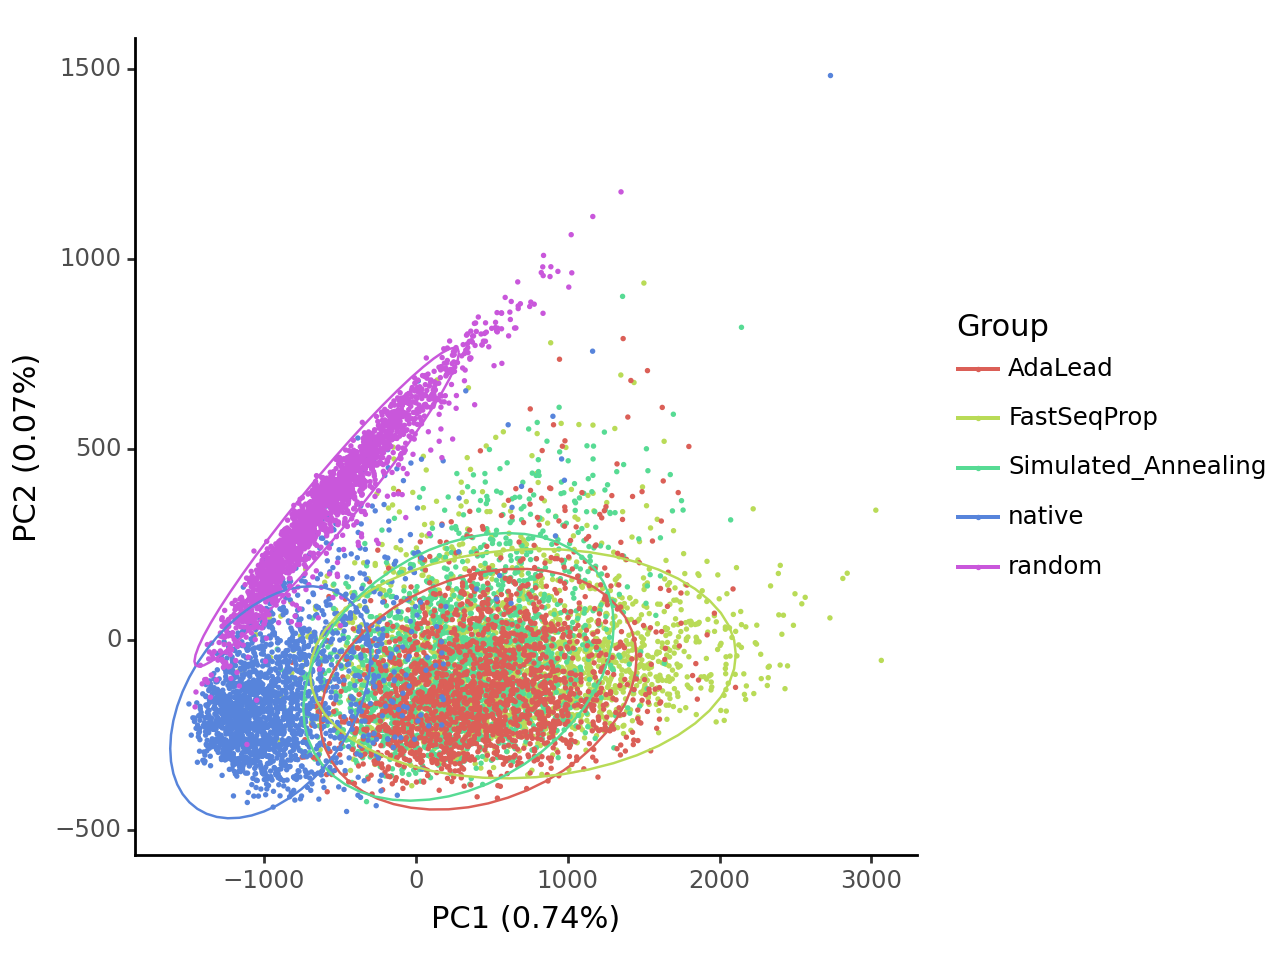

<Figure Size: (640 x 480)>

In [58]:
polygraph.visualize.pca_plot(emb)

In [59]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])

one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.57         0.10                 0.32    0.00    0.00
FastSeqProp             0.12         0.65                 0.22    0.00    0.01
Simulated_Annealing     0.33         0.18                 0.49    0.00    0.00
native                  0.00         0.01                 0.00    0.94    0.04
random                  0.00         0.01                 0.00    0.01    0.98
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0010    0.9375   0.0   0.0
Simulated_Annealing      0.0010    0.9375   0.0   0.0
AdaLead                  0.0000    0.9375   0.0   0.0
random                   0.0115    0.9375   0.0   0.0


{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead              1.000000e+00  1.786902e-08         1.232315e-09   
FastSeqProp          1.786902e-08  1.000000e+00         1.374500e-34   
Simulated_Annealing  1.232315e-09  1.374500e-34         1.000000e+00   
native               0.000000e+00  0.000000e+00         0.000000e+00   
random               0.000000e+00  0.000000e+00        1.084725e-241   

                           native         random  
AdaLead              0.000000e+00   0.000000e+00  
FastSeqProp          0.000000e+00   0.000000e+00  
Simulated_Annealing  0.000000e+00  1.084725e-241  
native               1.000000e+00   1.172607e-55  
random               1.172607e-55   1.000000e+00  }


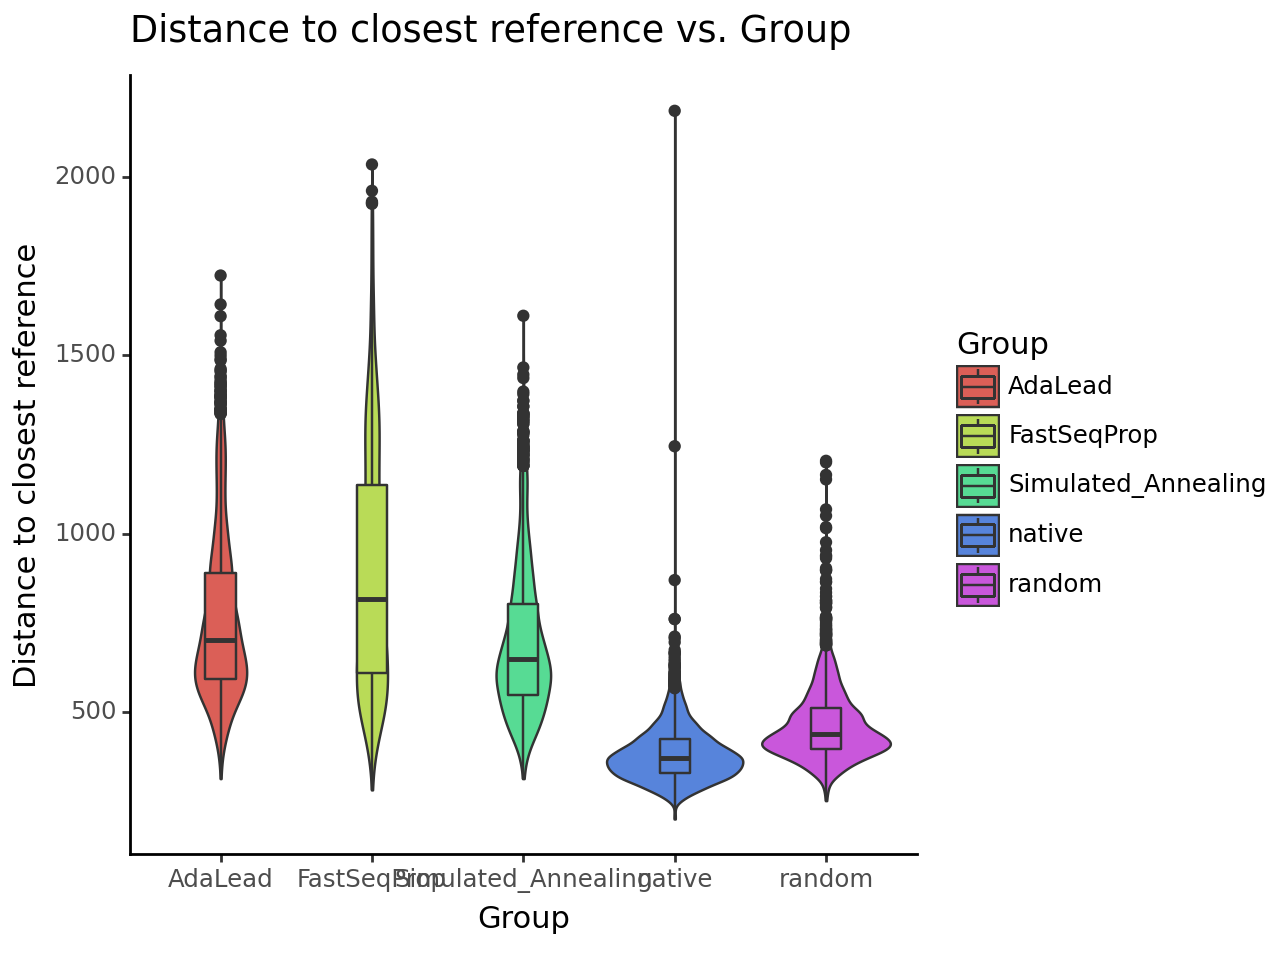

<Figure Size: (640 x 480)>

In [65]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference')

{'Kruskal': 0.0, 'Dunn':                            AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  1.756541e-11         4.555330e-01   
FastSeqProp           1.756541e-11  1.000000e+00         1.402829e-18   
Simulated_Annealing   4.555330e-01  1.402829e-18         1.000000e+00   
native                2.324677e-25  3.561196e-03         1.582926e-35   
random               1.965546e-274  0.000000e+00        1.753594e-244   

                           native         random  
AdaLead              2.324677e-25  1.965546e-274  
FastSeqProp          3.561196e-03   0.000000e+00  
Simulated_Annealing  1.582926e-35  1.753594e-244  
native               1.000000e+00   0.000000e+00  
random               0.000000e+00   1.000000e+00  }


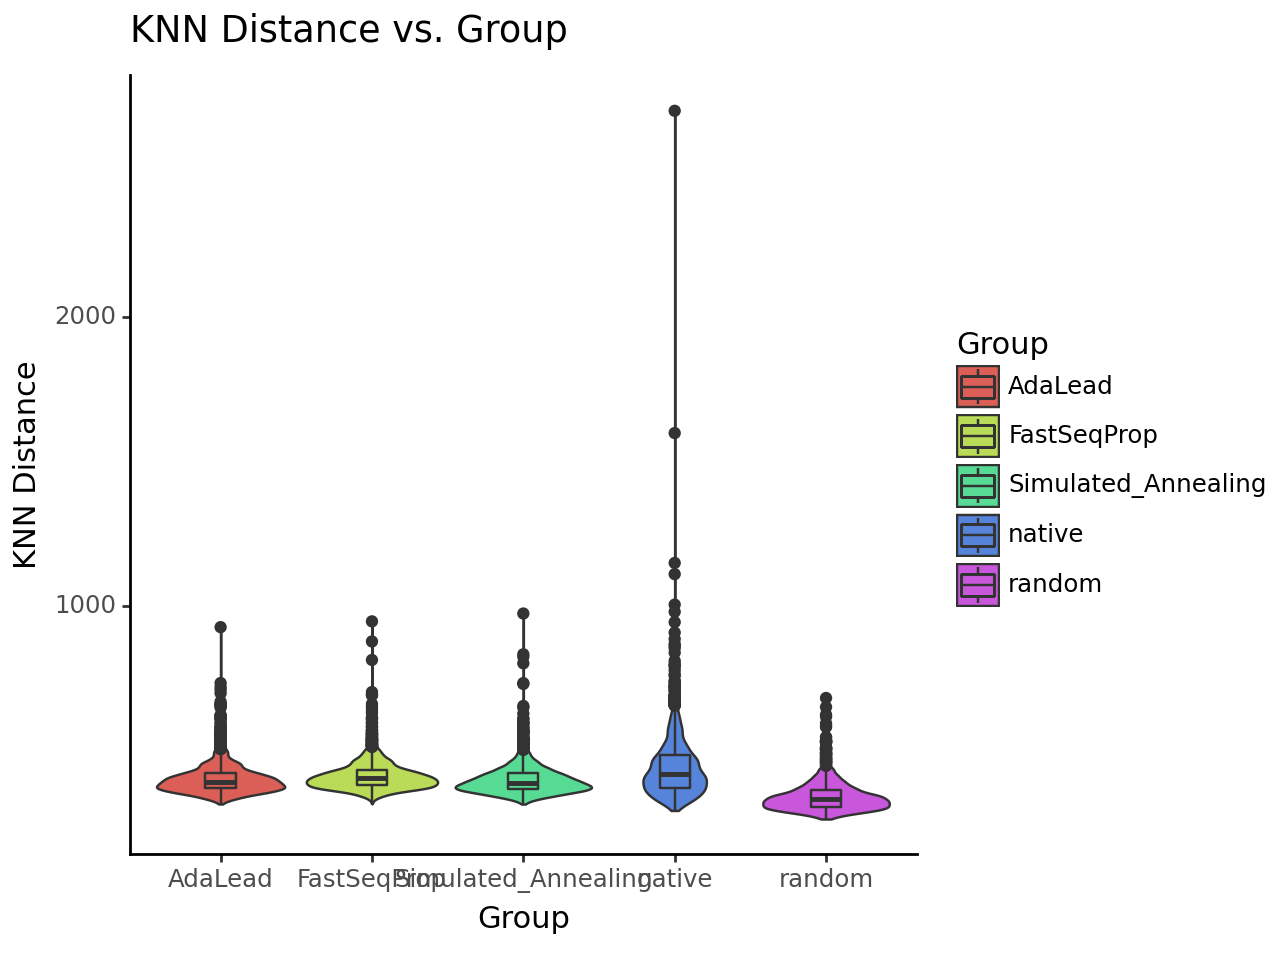

<Figure Size: (640 x 480)>

In [61]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance')

# 4. Language model

In [8]:
import polygraph.likelihood

In [9]:
model = polygraph.likelihood.load_hyenadna('/hyena-dna')

--2023-10-04 20:33:47--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 108.138.246.67, 108.138.246.71, 108.138.246.79, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535 [text/plain]
Saving to: ‘./config.json’

     0K                                                       100%  107M=0s

2023-10-04 20:33:47 (107 MB/s) - ‘./config.json’ saved [535/535]

--2023-10-04 20:33:47--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/weights.ckpt
Resolving huggingface.co (huggingface.co)... 108.138.246.85, 108.138.246.71, 108.138.246.79, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.85|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/23/bd/23bd011121e3699e6bfa5aa57274ac119b996f4c129b31145d6fffeaa6229b55/33558e085d0545

Loading config
Building model
Loading weights


In [13]:
seqs['Sequences'] = seqs['Sequence'] 
log_likelihood = polygraph.likelihood.compute_likelihood(seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

In [14]:
seqs.groupby('Group')['log_likelihood'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
AdaLead,2000.0,-287.501586,4.216266,-302.182177,-290.467936,-287.569923,-284.772083,-270.461006
FastSeqProp,2000.0,-288.569882,3.905383,-299.347361,-291.231285,-288.672371,-286.009660,-271.498029
Simulated_Annealing,2000.0,-288.727230,4.013310,-301.663131,-291.508654,-288.841514,-286.158346,-274.385393
native,2000.0,-258.871729,24.148949,-287.040948,-269.712393,-265.293411,-259.523115,-89.202084
random,2000.0,-288.944530,4.027626,-300.784194,-291.719527,-288.972722,-286.394444,-270.368807


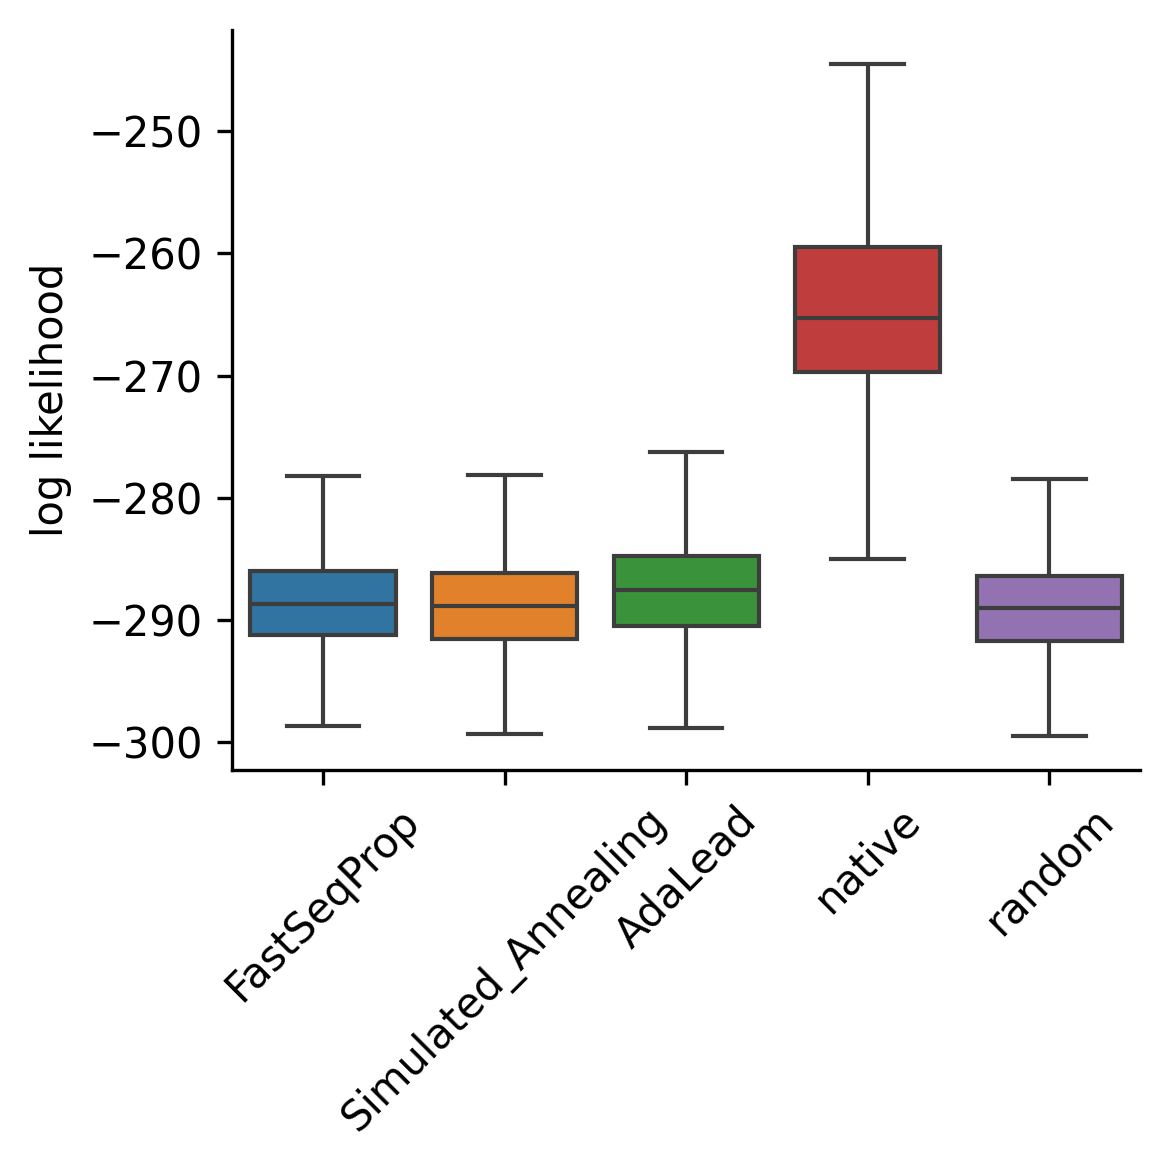

In [17]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood")